# Data preprocessing

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"warcoder","key":"6d8ee52880face577f8788157e9e0ce5"}'}

In [ ]:
! mkdir ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d robinreni/signature-verification-dataset

 97% 585M/601M [00:05<00:00, 92.4MB/s]
100% 601M/601M [00:05<00:00, 107MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = "signature-verification-dataset.zip"
with ZipFile(file_name, 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.losses import Loss
from keras_preprocessing import image

In [ ]:
def read_data(dir, data):
    images1 = [] 
    images2 = [] 
    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir,data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (100, 100))
        images1.append([img1])
        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])
        labels.append(np.array(data.iat[j, 2]))
    images1 = np.array(images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels

In [ ]:
train_dir = '/content/sign_data/train'
train_csv = '/content/sign_data/train_data.csv'
df_train = pd.read_csv(train_csv, header=None)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)
train_labels = to_categorical(train_labels)

In [ ]:
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)

In [ ]:
print(df_train.iloc[0, :])
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]

0             068/09_068.png
1    068_forg/03_0113068.PNG
2                          1
Name: 0, dtype: object


/content/sign_data/train/068/09_068.png


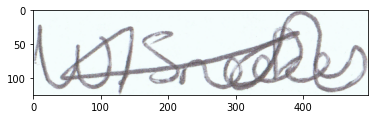

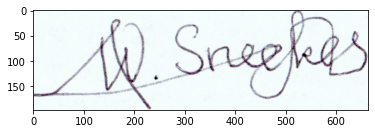

In [ ]:
img_original = plt.imread('/content/sign_data/train/'+img_org)
img_forged = plt.imread('/content/sign_data/train/'+img_frg)

print('/content/sign_data/train/'+img_org)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_original)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_forged)

# Simple Siamese Network

In [ ]:
def initialize_base_network(input_shape):
    clf = Sequential()
    clf.add(Convolution2D(64, (3,3),input_shape=input_shape))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Convolution2D(32, (3,3)))
    clf.add(Activation('relu'))
    clf.add(MaxPooling2D(pool_size=(2, 2)))
    clf.add(Flatten())
    clf.add(Dense(128, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    return clf
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
input_dim = (100, 100, 1)
base_network = initialize_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
vec_a = base_network(img_a)
vec_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vec_a, vec_b])
prediction = Dense(2, activation='softmax')(distance)
model = Model([img_a, img_b], prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           2194272     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [ ]:
adam = tf.keras.optimizers.Adam(lr=0.00008)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.fit([train_images1,train_images2],train_labels,validation_split=.30,batch_size=32,epochs=40)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
508/508 [==============================] - 17s 32ms/step - loss: 0.3008 - accuracy: 0.9962 - val_loss: 0.4926 - val_accuracy: 0.6813
Epoch 2/40
508/508 [==============================] - 16s 32ms/step - loss: 0.2819 - accuracy: 0.9980 - val_loss: 0.4858 - val_accuracy: 0.6958
Epoch 3/40
508/508 [==============================] - 16s 31ms/step - loss: 0.2649 - accuracy: 0.9988 - val_loss: 0.4723 - val_accuracy: 0.7124
Epoch 4/40
508/508 [==============================] - 16s 32ms/step - loss: 0.2484 - accuracy: 0.9995 - val_loss: 0.4611 - val_accuracy: 0.7288
Epoch 5/40
508/508 [==============================] - 16s 31ms/step - loss: 0.2341 - accuracy: 0.9997 - val_loss: 0.4518 - val_accuracy: 0.7386
Epoch 6/40
508/508 [==============================] - 16s 32ms/step - loss: 0.2193 - accuracy: 1.0000 - val_loss: 0.4394 - val_accuracy: 0.7535
Epoch 7/40
508/508 [==============================] - 16s 32ms/step - loss: 0.2066 - accuracy: 0.9999 - val_loss: 0.4254 - val_accuracy:

In [ ]:
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]
img_original = '/content/sign_data/train/'+img_org
img_forged = '/content/sign_data/train/'+img_frg

x = image.load_img(img_original, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

y = image.load_img(img_forged, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = model.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)
print(y_pred)

[[2.0543949e-09 1.0000000e+00]]
1


In [ ]:
if y_pred==1:
  print('Forged')
else:
  print('Real')

Forged


In [ ]:
model.save('my_model.h5')

In [ ]:
import keras

In [ ]:
loaded = keras.models.load_model("/content/my_model.h5")

In [ ]:
img_original = '/content/WhatsApp Image 2021-07-27 at 16.04.43.jpeg'
img_forged = '/content/WhatsApp Image 2021-07-27 at 16.05.05.jpeg'

x = image.load_img(img_original, target_size=(100, 100))    
x = image.img_to_array(x)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

y = image.load_img(img_forged, target_size=(100, 100))    
y = image.img_to_array(y)
y = tf.image.rgb_to_grayscale(y)
y = np.expand_dims(y, axis=0)
y = y/255.0
y_pred = loaded.predict([x,y])
print(y_pred)
y_pred = np.argmax(y_pred)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function euclidean_distance at 0x7fbae016a8c0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function euclidean_distance at 0x7fbae016a8c0>. Note that functions defined in certain environments, like the interactiv

In [ ]:
if y_pred==1:
  print('Forged')
else:
  print('Real')

Forged
